# Grid-Responsive Control of Indoor Air Temperature in Buildings With Differentiable Predictive Control

This notebook demonstrates how to use Differentiable Predictive Control (DPC) to control indoor air temperature in a single-zone building in response to grid signals.

---
## Motivation
Buildings today contribute to roughly 40 % of global energy use (approximately 64 PWh), of which a large portion is used for [heating, cooling, ventilation, and air-conditioning (HVAC)](https://en.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning). Advanced grid-responsive control can help reduce peak demand and energy cost, mitigate greenhouse gas emissions, and support renewable integration. However, most commercial building automation systems still rely on simple rule-based strategies.  

Below is a simplified representation of a building control scheme responding to real-time price signals or demand response events:  
<img src="./figs/building_control.PNG" width="500">

---
## Grid Response

[Grid Responsive Building Control](https://www.sciencedirect.com/science/article/pii/S0360544220327055?casa_token=QfpJZGrcwBEAAAAA:VwwPqJrRcl8wE14TyLvH62YJhaVYI8qVNAWzossdgmRxpEg9qm876iiWibkQKrjihKZBb17-ZA#fig4) is a broad collection of strategies, technologies, and methods that allow buildings to modulate their energy usage in response to signals from the grid. While many varieties of grid signals exist, the most common are variable pricing schemes, where utility providers create a rate schedule designed to incentivize energy load shifting [2]. Without onsite energy storage, one of the simplest methods for grid response is load shifting, demonstrated in the figure below. 

<img src="./figs/load_shifting.png" width="500">

##### In this notebook we demonstrate how Neuromancer and [Differentiable Predictive Control](https://www.sciencedirect.com/science/article/pii/S0959152422000981) (DPC) [[1]](https://www.sciencedirect.com/science/article/pii/S0959152422000981) can be used to train a controller to learn load shifting autonomously for a simple HVAC system. 
  
---

## References
[1] Drgoňa, Ján, et al. "Differentiable predictive control: Deep learning alternative to explicit model predictive control for unknown nonlinear systems." Journal of Process Control 116 (2022)

[2] Cappers, Peter, Charles Goldman, and David Kathan. "Demand response in US electricity markets: Empirical evidence." Energy 35.4 (2010)



## For Colab only:

In [3]:
# !pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

## Environment & Dependencies

In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import requests

from torch.utils.data import DataLoader
from torch.optim import AdamW
from copy import deepcopy
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.dataset import DictDataset
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.loggers import LossLogger
from neuromancer.psl import systems

# Building System

One of the key requirements for DPC is a differentiable system model. Although many system models fit into this framework, including neural network architectures, here we model the building using a discrete time linear state space model
  $$x_{k+1} = A\,x_k + B\,u_k + E\,d_k,\quad y_k = C\,x_k.$$  

In [95]:
"""
Create state‑space nodes for the building dynamics, observation, and disturbance.
"""
sys = systems['LinearSimpleSingleZone']()
    
A = torch.tensor(sys.A)
B = torch.tensor(sys.Beta)
C = torch.tensor(sys.C)
E = torch.tensor(sys.E)

# problem dimensions
nx = sys.nx           # number of states
nu = sys.nu           # number of control inputs
nd = sys.nD           # number of disturbances
nd_obs = sys.nD_obs   # number of observable disturbances
ny = sys.ny           # number of controlled outputs
nref = ny             # number of references

# control action bounds
umin = torch.tensor(sys.umin)
umax = torch.tensor(sys.umax)

def xnext(x, u, d):     # x_{k+1} = A x_k + B u_k + E d_k
    return x @ A.T + u @ B.T + d @ E.T
state_model = Node(xnext, ['x', 'u', 'd'], ['x'], name='SSM')

def ynext(x):           # y_k = C x_k
    return x @ C.T
obs_model = Node(ynext, ['x'], ['y'], name='y=Cx')

# measurable subset of disturbances, i.e. outdoor temperature may be observed where solar irradiance is not measured
def dist_obs(d):        
    return d[:, sys.d_idx]
dist_model = Node(dist_obs, ['d'], ['d_obs'], name='dist_obs')


In [96]:
nsteps = 25
nsamples = 2000
batch_size = 2000
horizon = 48 # 48 time steps at 5 minute intervals = 4 hours of lookahead
ymin = 18.0
ymax = 27.0

# Random Seed for reproducibility
rndSeed = 2345
np.random.seed(rndSeed)

## Load PG&E Pricing Data

The following cell downloads the file automatically from a version hosted on github and saves it locally

Alternatively, the data can be found at the following link, under FAQ, the question of "How Might Hourly Prices Vary?"

https://www.pge.com/en/account/rate-plans/hourly-flex-pricing.html#accordion-cf73526c80-item-e7816eba98

In [97]:
url="https://raw.githubusercontent.com/EladMichael/small_example_datasets/main/hourly-flex-prices-historical-sample.xlsx"
response = requests.get(url)

os.makedirs('data',exist_ok=True)
with open('data/hourly-prices.xlsx', 'wb') as f:
    f.write(response.content)

from pandas import read_excel
prices = read_excel('data/hourly-prices.xlsx',sheet_name='HFP_Prices',usecols=[10],skiprows=3).to_numpy().flatten()
prices = np.repeat(prices, 12).reshape((-1, 1)) # price is hourly, this makes it into 5 minute increments

### Plot the first few weeks of pricing data

Text(0, 0.5, '$ per kWh')

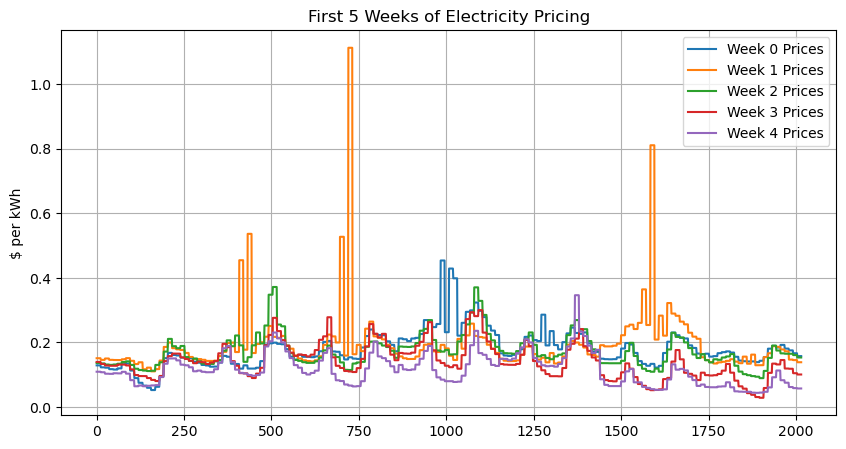

In [98]:
week = (7*24*60//5)
n_weeks = 5
plt.figure(figsize=(10,5))
for i in range(n_weeks):
    plt.plot(prices[i*week:(i+1)*week],label=f"Week {i} Prices")
plt.legend()
plt.grid(True)
plt.title(f"First {n_weeks} Weeks of Electricity Pricing")
plt.ylabel("$ per kWh")

## Dataset Preparation (Lookahead)

In order to effectively load-shift, the controller needs a prediction or lookahead of the incoming grid pricing. Typically these data are made available to users 24 hours ahead of time. In these cells, we create prediction vectors for the grid pricing (as well as outdoor temperature, aka weather forecast) to input to the controller. 

In [99]:
def make_lookahead(arr: torch.Tensor, horizon: int) -> torch.Tensor:
    """Construct look‑ahead feature matrix.

    Parameters
    ----------
    arr : Tensor [B, T, D]
    horizon : int
        Number of future steps to stack.

    Returns
    -------
    Tensor [B, T‑horizon+1, D*horizon]
    """
    B, nsteps, D = arr.shape
    if horizon < 1:
        raise ValueError("horizon must be >= 1")

    lookahead_arr = torch.zeros((B, nsteps - horizon + 1, D * horizon))
    for b in range(B):
        for step in range(nsteps - horizon + 1):
            lookahead_arr[b, step, :] = arr[b, step:step + horizon, :].flatten()
    return lookahead_arr

### Useful lambda function to make lookahead a little smoother to write/read
lookahead = lambda x: make_lookahead(x,horizon)

def build_lookahead_dataloader(
    sys,
    prices: np.ndarray,
    nsteps: int,
    nsamples: int,
    batch_size: int,
    ymin: float,
    ymax: float,
    name: str,
    horizon: int,
):
    """Create a DataLoader of random rollouts with look‑ahead exogenous signals."""

    ymin_gen = torch.distributions.Uniform(ymin, 0.5*(ymin+ymax))
    ymax_gen = torch.distributions.Uniform(0.5*(ymin+ymax), ymax)

    batched_ymin = ymin_gen.sample((nsamples, 1, sys.ny)).repeat(1, nsteps+horizon, 1)
    batched_ymax = ymax_gen.sample((nsamples, 1, sys.ny)).repeat(1, nsteps+horizon, 1)
    ymin_lookahead = lookahead(batched_ymin)
    ymax_lookahead = lookahead(batched_ymax)

    # choose random starting indices that line up with the same 5‑minute slot
    p_idxs = [np.random.randint(0, prices.shape[0]-nsteps-horizon) for _ in range(nsamples)]
    const = 288*((sys._D.shape[0]-nsteps-horizon)//288)
    d_idxs = [idx % const for idx in p_idxs]

    batched_dist = torch.stack([
        torch.tensor(sys._D[idx:idx+nsteps+horizon], dtype=torch.float) for idx in d_idxs
    ])
    batched_dist[:, :, 0] -= 10.0   # make it colder, to ensure only heating is needed
    dist_lookahead = lookahead(batched_dist[:, :, sys.d_idx])

    batched_price = torch.stack([
        torch.tensor(prices[idx:idx+nsteps+horizon], dtype=torch.float) for idx in p_idxs
    ])
    price_lookahead = lookahead(batched_price)

    batched_x0 = torch.stack([torch.tensor(sys.get_x0(), dtype=torch.float).unsqueeze(0)
                              for _ in range(nsamples)])

    data = DictDataset(
        {
            "x": batched_x0,
            "ymin_lookahead": ymin_lookahead,
            "ymax_lookahead": ymax_lookahead,
            "d": batched_dist[:, :nsteps, :],
            "d_obs_lookahead": dist_lookahead,
            "price_lookahead": price_lookahead,
            "d_idx": torch.tensor(d_idxs).reshape(nsamples, 1, 1),
        },
        name=name,
    )

    return DataLoader(data, batch_size=batch_size, collate_fn=data.collate_fn, shuffle=True)

def print_data(data):
    for key in data:
        if hasattr(data[key], 'shape'):
            print(key, " : ", data[key].shape, " , ", data[key].dtype)
        else:
            print(key, " : ", data[key])

In [100]:
# ---- dataset ---------------------------------------------------------------
train_loader = build_lookahead_dataloader(sys, prices,
                                          nsteps,
                                          nsamples,
                                          batch_size,
                                          ymin, ymax,
                                          name='train',
                                          horizon=horizon)

dev_loader = build_lookahead_dataloader(sys, prices,
                                        nsteps,
                                        nsamples//5,
                                        batch_size,
                                        ymin, ymax,
                                        name='dev',
                                        horizon=horizon)

### We can examine one element of the data loaders, to see the lookahead and other tensors shape

In [101]:
print_data(next(iter(train_loader)))

x  :  torch.Size([2000, 1, 4])  ,  torch.float32
ymin_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
ymax_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
d  :  torch.Size([2000, 25, 3])  ,  torch.float32
d_obs_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
price_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
d_idx  :  torch.Size([2000, 1, 1])  ,  torch.int64
name  :  train


## Neural Network Control Policy

The next layer of the DPC pipeline, after the building model and input datasets, is the control policy. In keeping with the motivation of the algorithm, each step must be differentiable, so we use a neural network to determine the policy mapping
  $$u_k = \pi_\theta\bigl(x_k,\;y_{\min},\;y_{\max},\;P_k\bigr)$$  
  that minimizes energy cost under price forecasts and enforces  
  $$y_{\min}\le y_k\le y_{\max}.$$

In [102]:
h_size = 32
n_layers = 2

no_forecast_inputs = ['y']
forecast_inputs = ['d_obs', 'ymin', 'ymax', 'price']
forecast_inputs = [var+'_lookahead' for var in forecast_inputs]
inputs = no_forecast_inputs+forecast_inputs

forecast_sizes = (horizon)*np.array([sys.nD_obs, sys.ny, sys.ny, 1])
no_forecast_sizes = [sys.ny]
input_size = sum(no_forecast_sizes) + sum(forecast_sizes)

#### Here we use an MLP with built in bounds, from Neuromancer, to enforce the input constraints
  $$u_{\min}\le u_k\le u_{\max}.$$

In [103]:
"""
Fully‑connected neural network policy with element‑wise bounds.
"""
net = blocks.MLP_bounds(
    insize=input_size,
    outsize=sys.nu,
    hsizes=[h_size]*n_layers,
    nonlin=torch.nn.LeakyReLU,
    min=torch.tensor(sys.umin),
    max=torch.tensor(sys.umax),
)
policy = Node(net, inputs, ['u'], name='policy')

## The two models: Grid Responsive and Vanilla (No Pricing Data)

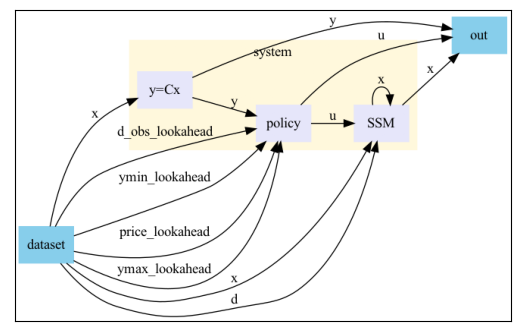

In [104]:
resp_sys = System([obs_model, policy, state_model],
                   nsteps=nsteps,
                   name='cl_system')
vanilla_sys = deepcopy(resp_sys)
resp_sys.show()

## Loss Functions
The gains here can be tuned to change the emphasis of the solver, on price or on temperature constraint satisfaction. The general form of the optimization problem here is  
  $$\begin{aligned}
  &\min_\theta\;\sum_{k=1}^{N-1} q_p\|u_k\|_{P_k}^2 + q_t||\max(0,y_k - y_{\max},y_{\min}-y_k)||_2^2\\
  &\text{subject to dynamics and bound constraints as above,}
  \end{aligned}$$  
  where $P_k$ is the time-varying price penalty and $q_p,q_t\in\mathcal{R}$ the gains which balance the tradeoff of energy/price minimization and temperature tracking. We train implement two different loss functions here, one with pricing info and one only penalizing the action input, i.e. a "vanilla" DPC implementation, to compare the effect of pricing on the objective function.

In [105]:
price_gain = 1
action_gain = 0.03
smooth_gain = 0
comfort_gain = 5e06

y_var = variable('y')
u_var = variable('u')
ymin_var = variable('ymin_lookahead')[:, :-1, 0:1]
ymax_var = variable('ymax_lookahead')[:, :-1, 0:1]
price_var = variable('price_lookahead')[:, :-1, 0:1]

In [106]:
"""
Composite loss:
  1. energy use weighted by real‑time price
  3. comfort constraints (soft)
"""

# price-weighted energy use
price_loss_var = price_gain * ((u_var * price_var) == torch.zeros_like(u_var)) ^ 2
action_loss = action_gain * (u_var == torch.zeros_like(u_var)) ^ 2
comfort_lower = comfort_gain * (y_var > ymin_var)
comfort_upper = comfort_gain * (y_var < ymax_var)

price_loss_var.name = 'price_loss'
action_loss.name = 'action_loss'
comfort_lower.name = 'y_min'
comfort_upper.name = 'y_max'

responsive_objective = [price_loss_var]
vanilla_objective = [action_loss]
constraints = [comfort_lower, comfort_upper]

loss_responsive = PenaltyLoss(responsive_objective, constraints)
loss_vanilla = PenaltyLoss(vanilla_objective, constraints)

## Differentiable Optimal Control Problem

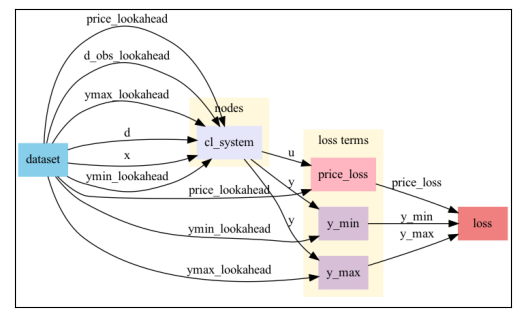

In [107]:
problem_responsive = Problem(nodes=[resp_sys], loss=loss_responsive)
problem_vanilla = Problem(nodes=[vanilla_sys], loss=loss_vanilla)
problem_responsive.show()

# Solve Problem

In [108]:
opt_responsive = AdamW(problem_responsive.parameters(), lr=1e-3)

logger = LossLogger(verbosity=1, stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem_responsive,
    train_loader,
    dev_loader,
    optimizer=opt_responsive,
    epochs=200,
    logger=logger,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=20,
    patience=50,
)

# Train control policy
# print_data(next(iter(train_loader)))
best_responsive = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_responsive)

None
Number of parameters: 7297
epoch: 0	train_loss: 2453900.75000	dev_loss: 1444343.00000	eltime:  0.31483
epoch: 1	train_loss: 1728411.25000	dev_loss: 1414355.75000	eltime:  0.47917
epoch: 2	train_loss: 1681584.62500	dev_loss: 1494455.87500	eltime:  0.63515
epoch: 3	train_loss: 1683190.25000	dev_loss: 1471263.62500	eltime:  0.76985
epoch: 4	train_loss: 1660849.25000	dev_loss: 1394842.50000	eltime:  0.91530
epoch: 5	train_loss: 1625111.75000	dev_loss: 1391000.00000	eltime:  1.07390
epoch: 6	train_loss: 1616880.25000	dev_loss: 1407145.62500	eltime:  1.34542
epoch: 7	train_loss: 1602194.62500	dev_loss: 1391441.87500	eltime:  1.50231
epoch: 8	train_loss: 1589598.12500	dev_loss: 1381527.75000	eltime:  1.65120
epoch: 9	train_loss: 1578635.37500	dev_loss: 1368543.12500	eltime:  1.79401
epoch: 10	train_loss: 1566856.00000	dev_loss: 1371370.50000	eltime:  1.97267
epoch: 11	train_loss: 1550134.75000	dev_loss: 1372356.75000	eltime:  2.11247
epoch: 12	train_loss: 1537558.00000	dev_loss: 1341730.

<All keys matched successfully>

In [109]:
opt_vanilla = AdamW(problem_vanilla.parameters(), lr=1e-3)

#  Neuromancer trainer
trainer = Trainer(
    problem_vanilla,
    train_loader,
    dev_loader,
    optimizer=opt_vanilla,
    epochs=200,
    logger=logger,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=20,
    patience=50,
)

# Train control policy
# print_data(next(iter(train_loader)))
best_vanilla = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_vanilla)

Number of parameters: 7297
epoch: 0	train_loss: 2362401.25000	dev_loss: 1427292.25000	eltime:  36.44967
epoch: 1	train_loss: 1410382.12500	dev_loss: 1418517.25000	eltime:  36.57709
epoch: 2	train_loss: 1402614.75000	dev_loss: 1501140.37500	eltime:  37.47873
epoch: 3	train_loss: 1487748.37500	dev_loss: 1465422.50000	eltime:  37.70520
epoch: 4	train_loss: 1451127.50000	dev_loss: 1406175.50000	eltime:  37.88537
epoch: 5	train_loss: 1396515.12500	dev_loss: 1406499.87500	eltime:  38.01239
epoch: 6	train_loss: 1400651.25000	dev_loss: 1405085.25000	eltime:  38.13641
epoch: 7	train_loss: 1392481.25000	dev_loss: 1407035.50000	eltime:  38.26631
epoch: 8	train_loss: 1389361.50000	dev_loss: 1390732.37500	eltime:  38.40972
epoch: 9	train_loss: 1383276.00000	dev_loss: 1381471.12500	eltime:  38.56206
epoch: 10	train_loss: 1379068.00000	dev_loss: 1370180.62500	eltime:  38.78727
epoch: 11	train_loss: 1373062.75000	dev_loss: 1370178.12500	eltime:  39.06209
epoch: 12	train_loss: 1366771.25000	dev_loss: 1

<All keys matched successfully>

### Create test dataset, and test trained controller

In [110]:
nsteps_test = 2017

# generate disturbance signals
p_idx = np.random.randint(0, prices.shape[0]-nsteps_test-horizon)
d_idx = p_idx % (288*((sys._D.shape[0]-nsteps_test-horizon)//288))

dist = torch.tensor(
    sys._D[d_idx:d_idx+nsteps_test+horizon], dtype=torch.float).unsqueeze(0)

# make it colder!
dist[:, :, 0] -= 10

dist_lookahead = lookahead(dist[:, :, sys.d_idx])
price = torch.tensor(
    prices[p_idx:p_idx+nsteps_test+horizon], dtype=torch.float).unsqueeze(0)
price_lookahead = lookahead(price)

ymin_sig = ymin*torch.ones((1, nsteps_test+horizon, 1))
ymax_sig = ymax*torch.ones((1, nsteps_test+horizon, 1))

ymin_lookahead = lookahead(ymin_sig)
ymax_lookahead = lookahead(ymax_sig)

# initial data for closed loop simulation
x0 = torch.tensor(
    sys.get_x0(), dtype=torch.float).reshape(1, 1, sys.nx)

test_data = {'x': x0,
        'ymin_lookahead': ymin_lookahead,
        'ymax_lookahead': ymax_lookahead,
        'd': dist[:, :nsteps_test, :],
        'd_obs_lookahead': dist_lookahead,
        'price_lookahead': price_lookahead,
        'd_idx': torch.tensor(d_idx).reshape(1, 1, 1)}

In [111]:
resp_sys.nsteps = nsteps_test
vanilla_sys.nsteps = nsteps_test

traj_responsive = resp_sys(test_data)
traj_vanilla = vanilla_sys(test_data)

# Uncomment to examine the shapes of the fields
# print_data(traj)

## Plot Results

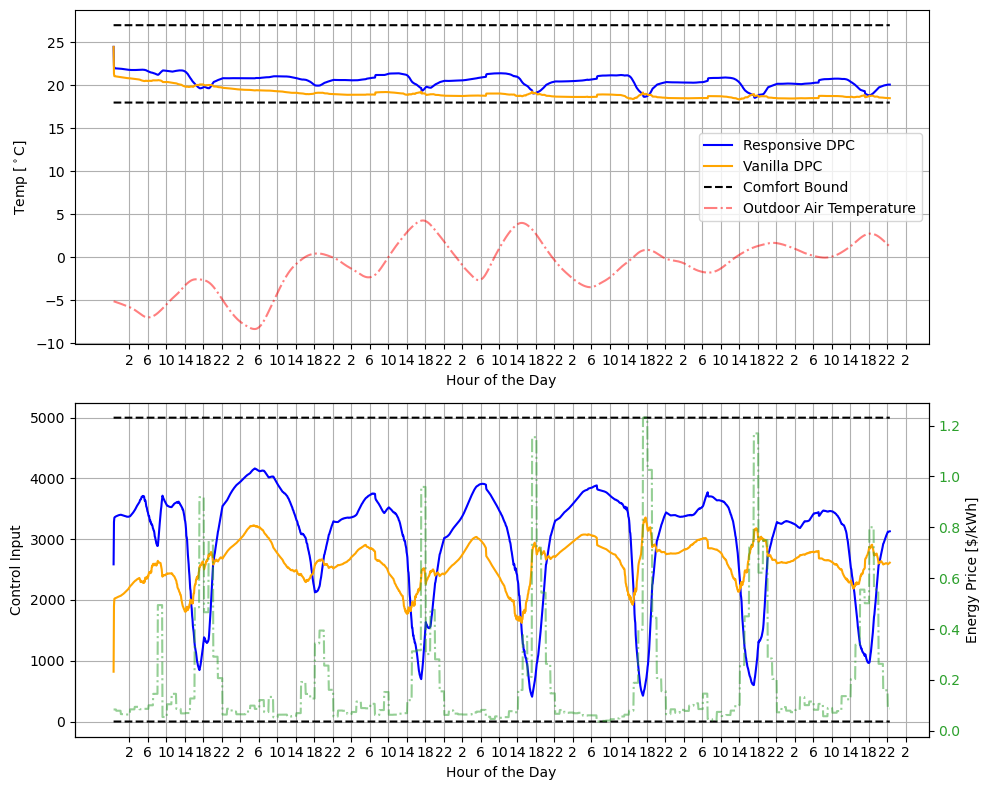

In [112]:
nZones = 1
nsteps = traj_responsive['y'].shape[1]
t = np.arange(0, nsteps_test)

d_hour = 4

offset = traj_responsive['d_idx'].detach().numpy().flatten()[0] % 48

hour_ticks = np.arange(offset, nsteps+offset+1, d_hour*12)

hour_0 = (traj_responsive['d_idx']+offset)//12

hour_labels = np.arange(hour_0, hour_0+1+nsteps//12, d_hour) % 24

fig, axs = plt.subplots(2, figsize=(10, 8))

def get(traj, key, nsteps):
    return traj[key][:, :nsteps, 0].detach().numpy().flatten()

ymin = traj_responsive['ymin_lookahead'][:, :nsteps, 0:nZones].detach().numpy()
ymax = traj_responsive['ymax_lookahead'][:, :nsteps, 0:nZones].detach().numpy()
prices = traj_responsive['price_lookahead'][:,:nsteps, 0:1].detach().numpy().flatten()


axs[0].plot(t, get(traj_responsive, 'y', nsteps),
               "-", color="blue", label="Responsive DPC")
axs[0].plot(t, get(traj_vanilla, 'y', nsteps),
               "-", color="orange", label="Vanilla DPC")

axs[0].plot(t, ymin[:, :, 0].flatten(), "--",
               color="black", label="Comfort Bound")
axs[0].plot(t, ymax[:, :, 0].flatten(), "--", color="black")
axs[0].plot(t, get(traj_responsive, 'd', nsteps), "-.",
               color="red", alpha=0.5, label="Outdoor Air Temperature")
axs[0].grid()
axs[0].set_ylabel(r'Temp [$^\circ$C]')
axs[0].set_xticks(hour_ticks, hour_labels)
axs[0].set_xlabel("Hour of the Day")
axs[0].legend(loc='best')


axs[1].plot(t, get(traj_responsive, 'u', nsteps), "-", color="blue",label="Responsive DPC")
axs[1].plot(t, get(traj_vanilla, 'u', nsteps), "-", color="orange",label="Vanilla DPC")
if sys.umax.size == 1:
    axs[1].plot(t, [sys.umax]*nsteps, "--", color="black")
    axs[1].plot(t, [sys.umin]*nsteps, "--", color="black")
else:
    axs[1].plot(t, [sys.umax[zone]]*nsteps, "--", color="black")
    axs[1].plot(t, [sys.umin[zone]]*nsteps, "--", color="black")
axs[1].set_ylabel('Control Input')
axs[1].set_xticks(hour_ticks, hour_labels)
axs[1].set_xlabel("Hour of the Day")
axs[1].grid()

color = 'tab:green'
ax2 = axs[1].twinx()
ax2.set_ylabel('Energy Price [$/kWh]')
ax2.plot(t, prices,
         "-.", color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Conclusion

We demonstrate the potential to add a grid responsive element to DPC in the form of variable electricity pricing, demonstrated using a simple HVAC situation with a single zone modelled by an LTI system. The grid responsive controller learned load shifting behavior, using more electricity when it was cheap to avoid usage when it was expensive, by training with awareness of grid pricing data. This is shown by comparing to a vanilla controller which is not trained on a price sensitive objective.

### How to Apply This to Other Applications:

1. **Data Preparation**:
   - Implement a lookahead data structure, so your controller has access to predictions of future inputs


2. **Objective Function**:
   - Formulate an objective which codifies the possible trade-off between current and future penalties, i.e. electricity usage now to heat the building vs. electricity usage later.


3. **Evaluation**:
   - Train a controller without the responsiveness to compare the effacacy of the approach

---

### Future Research Directions:

- Explore sensitivity of input correlation, especially in time-series situations
- Validate approach in deployment
